In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time

import mlrose
import pandas as pd
import traitlets.utils.bunch
from mlrose import NNGSRunner
from sklearn.datasets import load_iris
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np


def process_abalone_ternary():
    df = pd.read_csv('data/abalone.data', names=["Sex", "Length", "Diameter", "Height",
                                                 "Whole weight", "Shucked weight", "Viscera weight",
                                                 "Shell weight", "Rings"])
    df = df[(df["Height"] != 1.13) & (df['Height'] != 0.515)]

    # deal with categorical data
    df.loc[df.Sex == 'M', 'Male'] = 1.
    df.loc[df.Sex == 'F', 'Female'] = 1.
    df.loc[df.Sex == 'I', 'Infant'] = 1.
    df.fillna(0, inplace=True)

    # bucketize rings
    df.loc[df.Rings < 11, 'Rings'] = 1.
    df.loc[(df.Rings < 21) & (df.Rings > 10), 'Rings'] = 2.
    df.loc[df.Rings > 20, 'Rings'] = 3.

    return traitlets.Bunch(
        data=df[['Male', 'Female', 'Infant', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
                 'Viscera weight', 'Shell weight']].values,
        target=df[['Rings']].values,
        target_names=df["Rings"].unique(),
        DESCR='abalone dataset...',
        feature_names=['Male', 'Female', 'Infant', "Length", "Diameter", "Height",
                       "Whole weight", "Shucked weight", "Viscera weight",
                       "Shell weight"],
    )

data = process_abalone_ternary()
# Split data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, \
                                                    test_size = 0.2, random_state = 3)

# Normalize feature data
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.reshape(-1, 1)).todense()


In [2]:
# Initialize neural network object and fit object
csv_path = 'out/nn_simulated_annealing.csv'
cols = ['iter', 'train_accuracy', 'test_accuracy', 'test_f1', 'fit_time', 'loss']
data = []
for i in [1, 50, 100, 200, 400, 800, 1600, 3200]:
    st=time.time()
    nn_modelrhc = mlrose.NeuralNetwork(hidden_nodes = [10], activation = 'relu', \
                                     algorithm = 'random_hill_climb', max_iters = i, \
                                     bias = True, is_classifier = True, learning_rate = 0.01, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100, \
                                     random_state = 3, schedule=mlrose.GeomDecay(init_temp=100))

    nn_modelrhc.fit(X_train_scaled, y_train_hot)
    fn=time.time()

    from sklearn.metrics import accuracy_score

    # Predict labels for train set and assess accuracy

    y_train_pred = nn_modelrhc.predict(X_train_scaled)

    y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)


    # Predict labels for test set and assess accuracy
    y_test_pred = nn_modelrhc.predict(X_test_scaled)

    y_test_accuracy = accuracy_score(y_test_hot, y_test_pred)
    
    y_test_f1 = f1_score(y_test_hot, y_test_pred, average='macro')

    row = [i, y_train_accuracy, y_test_accuracy, y_test_f1, fn-st, nn_modelrhc.loss]
    data.append(row)
    print (row)
    nn_modelrhc=[]
result = pd.DataFrame(data, columns=cols)
result.to_csv(csv_path, index=None)

[1, 0.2934131736526946, 0.2934131736526946, 0.2039827325651833, 0.013078927993774414, 1.4991119592353195]
[50, 0.3023952095808383, 0.3065868263473054, 0.20835612764816305, 0.16487812995910645, 1.4692570462183947]
[100, 0.3086826347305389, 0.3149700598802395, 0.2120704655291201, 0.38423895835876465, 1.4340441405763584]
[200, 0.3212574850299401, 0.32934131736526945, 0.21724668929637878, 0.6670577526092529, 1.385323845689026]
[400, 0.35449101796407184, 0.36167664670658684, 0.22461670126370223, 1.2584052085876465, 1.2690293154450145]
[800, 0.43233532934131735, 0.43353293413173655, 0.24091189804482993, 2.5244081020355225, 1.1035856567789721]
[1600, 0.6347305389221557, 0.6419161676646706, 0.263520157325467, 5.072179079055786, 0.8226777358737674]
[3200, 0.6787425149700599, 0.6778443113772455, 0.31315292495990305, 10.379875898361206, 0.63973515962698]


In [20]:
pd.read_csv(csv_path)

,iter,train_accuracy,test_accuracy,test_f1,fit_time,loss
0,1,0.288623,0.291018,0.203035,0.013120,1.502224
1,50,0.276048,0.282635,0.199313,0.239487,1.575326
2,100,0.167665,0.164072,0.133195,0.462396,1.619326
3,200,0.122754,0.135329,0.113657,0.912107,1.710558
4,400,0.269162,0.276647,0.186919,1.839042,1.528307
5,800,0.529042,0.542515,0.252370,3.603149,1.125543
6,1600,0.708982,0.698204,0.418072,7.179452,0.578948
7,3200,0.722754,0.694611,0.432929,13.996794,0.553143


In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_nn_score_vs_iters(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')


    plt.plot(df['iter'], df['train_accuracy'], 'x-', color="r",
             label="Training Accuracy")
    plt.plot(df['iter'], df['test_accuracy'], 'x-', color="g",
             label="Test Accuracy")
    plt.plot(df['iter'], df['test_f1'], '--', color="g",
             label="Test F1")

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title('Score vs. Iteration for training and test data - ' + alg_name,
              fontsize=14)
    plt.legend()
    plt.savefig(
        'images/' + alg_name + 'nn-score-vs-iteration-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt


def plot_nn_fit_time_vs_iter(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')


    plt.plot(df['iter'], df['fit_time'], 'o-', color="b")

    plt.ylabel('Fit Time', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title(alg_name, fontsize=14)
    plt.savefig('images/' + alg_name + 'nn-fittime-vs-time-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt

def plot_nn_loss_vs_iter(alg_name):
    df = pd.read_csv('out/nn_' + alg_name + '.csv')

    plt.style.use('seaborn')

    plt.plot(df['iter'], df['loss'], 'o-', color="y")

    plt.ylabel('Loss', fontsize=14)
    plt.xlabel('Iteration', fontsize=14)
    plt.title(alg_name, fontsize=14)
    plt.savefig('images/' + alg_name + 'nn-loss-vs-iteration-' + str(datetime.now()) + '.png')
    plt.show()
    plt.close()
    return plt

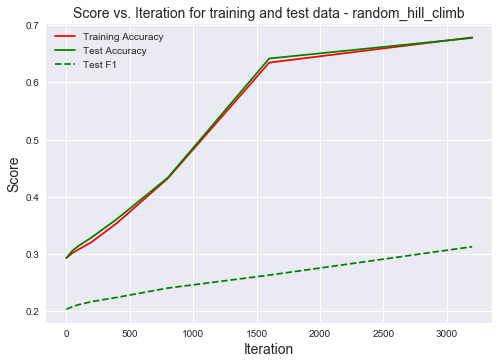

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [17]:
alg_name = 'random_hill_climb'
plot_nn_score_vs_iters(alg_name)

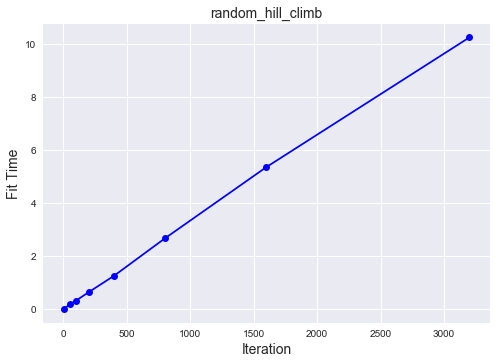

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [18]:
plot_nn_fit_time_vs_iter(alg_name)

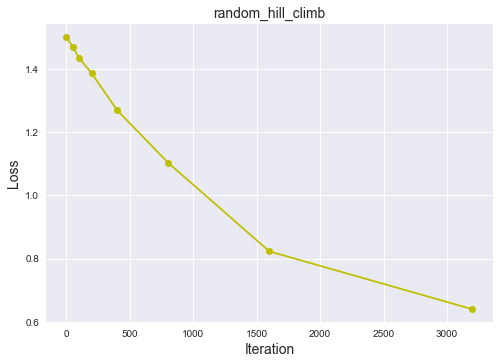

<module 'matplotlib.pyplot' from '//anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [19]:
plot_nn_loss_vs_iter(alg_name)